In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.utils import degree as deg
from tqdm import tqdm

import sys
import os
def path_link(path:str):
    sys.path.append(path)

path_link('master/code/lib')

from norm import normalizeGraph


In [30]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
DISPLAY_POSS = ['sparsity_peaks',
                'sparsity_bar',
                'error_time',
                'MSE_rollout',
                'heatmap',
                'MSD',
                'scattering',
                'jacobian',
                'angle_error',
                'norm_error',
                'degree_error',
                'mean_distance_neighbors',
                'speed_effect_error',
                'diff_speed_effect_error',
                # distribution,
                # linearPlot,
                'l1_error'
                ]

### ---  dict

In [206]:
def getDisplayDict():
    d = {}

    for poss in DISPLAY_POSS:
        d[poss] = {}

        for elem in ['wandb', 'plot', 'pandas', 'param']:
            d[poss][elem] = None

    return d    



def computeDictBool(d):
    """
    Adds a boolean to state if the different computations are necesary
    """

    for poss in d.keys():

        d[poss]['comp'] = False

        for elem in d[poss].keys():
            if d[poss][elem] is not None:
                d[poss]['comp'] = True
                break

    return d

In [18]:
class SimulationData():
    def __init__(self, data):
        self.data = data # list of graph

In [35]:
DISPLAY_PATH = '/master/code/experimental/new_plots_functions/dumb'

### --- Load a model

In [42]:
PATH = '/master/code/analyze_models/exps/test_new_activation_0'

MODEL_PATH = '/master/code/models/mod_base'

In [43]:
def findModels(path):
    pathLists = []
    for root, dirs, files in tqdm(os.walk(path)):
            for file in files:
                  
                  if file.endswith('.pt'):
                        pathLists.append(os.path.join(root, file))


    return pathLists


def delete_wandb_dirs(start_path):
    for root, dirs, files in os.walk(start_path, topdown=False):
        for dir_name in dirs:
            if dir_name == "wandb":
                dir_path = os.path.join(root, dir_name)
                print(f"Deleting: {dir_path}")
                shutil.rmtree(dir_path)


def getLoader(path, batch_size = 32, shuffleBool = True, root = None, jsonFile = None, mode = 'training'):
    datasetTraining = dl.DataLoader2(root, path = path, jsonFile = jsonFile, mode = mode)
    loader = DataLoader(datasetTraining, batch_size=batch_size, shuffle = shuffleBool)
    
    return loader


def getName(path):
    run_name = path.split('/')[-3]

    model_type = path.split('/')[-1].split('.')[0]

    if 'best' in model_type:
        model_type = '_best'

    else:
         model_type = '_latest'

    name = run_name + model_type

    return name


def getModelName(key):

    name = ''

    #if 'simplest' in key:
    #    name = name + 'simplest'
    
    name = name + 'simplest'

    ## other possibilities

    if 'no-dropout' in key:
        name = name + '_no-dropout'
    else:
        name = name + '_dropout'

    if 'no-encoder' in key:
        name = name + '_no-encoder'
    else:
        name = name + '_encoder'

    if 'relu' in key:
        name = name + '-relu'

    return name
         

def loadModel(modelName:str, inputShape:int = 8, edges_shape = 5, path = None):
    """ 
    Function to import the model

    Args:
    -----
        - `modelName`: name of the model
        - `inputShape`: inout shape of the NN
        - `edges_shape`: edge shape of the NN
        - `path`: path where the models are
    """

    sys.path.append(path)

    loadFun = __import__(f'{modelName}', fromlist = ('loadNetwork'))

    model = loadFun.loadNetwork(inputShape, edges_shape)

    return model



def findLoader(key):

    # remains initial conditions to consider
    if 'normal' in key:
        if '0_01' in key:
            dataloader_path = '/master/code/simulation/path/mew_0_01_normal.json'

        else:       # 0.001
            dataloader_path = '/master/code/simulation/path/mew_0_001_normal.json'

    else:       # noisy
        if '0_01' in key:
            dataloader_path = '/master/code/simulation/path/mew_0_01_noisy.json'

        else:       # 0.001
            dataloader_path = '/master/code/simulation/path/mew_0_001_noisy.json'

    print(dataloader_path)


    return getLoader(None, 128, True, None, dataloader_path, 'test')

In [45]:
model_list = findModels(PATH)
print(model_list)
print(len(model_list))

16it [00:00, 48.16it/s]

['/master/code/analyze_models/exps/test_new_activation_0/test_new_activation/master-thesis_normal_classic_dt-0.001_lr-0.0005_batch-16_encoder-no-encoder_dropout-dropout_relu-exp/model_trained/simplest_drop_no-enc_aug_best.pt', '/master/code/analyze_models/exps/test_new_activation_0/test_new_activation/master-thesis_normal_classic_dt-0.001_lr-0.0005_batch-16_encoder-no-encoder_dropout-dropout_relu-exp/model_trained/simplest_drop_no-enc_aug_latest.pt', '/master/code/analyze_models/exps/test_new_activation_0/test_new_activation/master-thesis_normal_classic_dt-0.001_lr-0.005_batch-16_encoder-no-encoder_dropout-dropout_relu-exp/model_trained/simplest_drop_no-enc_aug_best.pt', '/master/code/analyze_models/exps/test_new_activation_0/test_new_activation/master-thesis_normal_classic_dt-0.001_lr-0.005_batch-16_encoder-no-encoder_dropout-dropout_relu-exp/model_trained/simplest_drop_no-enc_aug_latest.pt', '/master/code/analyze_models/exps/test_new_activation_0/test_new_activation/master-thesis_nor

In [46]:
model_path = model_list[7]

name_plot = getName(model_path)
try:
    model = loadModel(getModelName(name_plot), path=MODEL_PATH)
    std_dict = torch.load(model_path)
    model.load_state_dict(std_dict)
    model = model.to(DEVICE)
    model.eval()
except:
    print("njfngkvjsdn")

>>>> loading simplest
INFO >>> relu end of message MLP
INFO >>> with NO encoder
INFO >>> with NO dropout


### ---- 1 step measure

> get some data

In [47]:
import simulation as sim
import features as ft

def getSim():
    lim = 0.85 * 100

    xPos = np.linspace(-lim, lim, 10)
    yPos = np.linspace(-lim, lim, 10)
    gridX, gridY = np.meshgrid(xPos, yPos)
    delta = np.random.uniform(0, 7, gridX.shape + (2,))

    gridX2 = gridX + delta[:, :, 0]
    gridY2 = gridY + delta[:, :, 1]

    pos = np.stack([gridX.ravel(), gridY.ravel()], axis=1)
    pos_perturbed = np.stack([gridX2.ravel(), gridY2.ravel()], axis=1)

    pos = np.concatenate([pos, pos_perturbed], axis=0)

    angles = np.random.rand(pos.shape[0]) * 2 * np.pi

    data = sim.compute_main(200, (60, 3.5, 70, 0.5), 120, T = 200, initialization = (pos, angles), dt = 0.001)[0]

    x, y, attr, inds = ft.processSimulation(data)

    return x, y, attr, inds

In [48]:
data = []
for i in range(5):

    xList, yList, attrList, indsList = getSim()
    simul_graphs = [Data(x = xList[t][:, 2:], y = yList[t] , edge_attr = attrList[t], edge_index = indsList[t]) for t in range(len(xList))]
    s = SimulationData(simul_graphs)
    data.append(s)

v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 200/200 [00:02<00:00, 69.60it/s]


v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 200/200 [00:02<00:00, 70.96it/s]


v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 200/200 [00:02<00:00, 81.87it/s] 


v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 200/200 [00:03<00:00, 51.68it/s]


v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 200/200 [00:03<00:00, 52.07it/s]


> perform the 1 step measures

In [207]:
d = getDisplayDict()

d['sparsity_peaks']['plot'] = os.path.join(DISPLAY_PATH, 'l1_peaks.png')
d['sparsity_bar']['plot'] = os.path.join(DISPLAY_PATH, 'l1_bar.png')
d['angle_error']['plot'] = os.path.join(DISPLAY_PATH, 'angle_error.png')
d['norm_error']['plot'] = os.path.join(DISPLAY_PATH, 'norm_error.png')
d['degree_error']['plot'] = os.path.join(DISPLAY_PATH, 'degree_error.png')
d['speed_effect_error']['plot'] = os.path.join(DISPLAY_PATH, 'speed_effect_error.png')


d = computeDictBool(d)

In [51]:
def getStdMessage(model, attr):
    model.eval()
    with torch.no_grad():
        v = model.GNN.message(None, None, attr).cpu().detach().numpy()
    return v



def plotStdMessage(messages):

    std = np.std(messages, axis = 0)

    plt.plot(std)
    plt.xlabel('features')
    plt.ylabel('Standard Deviation')

    return std




In [154]:
def plotBoxPlot(diff, vals, bins, xlabel = 'X values', ylabel = 'y values', showfliers = False):

    groups = np.digitize(diff, bins)
    grouped_vals = {i: [] for i in range(len(bins)+1)}


    for i in range(len(groups)):
        grouped_vals[groups[i]].append(vals[i])
    
    centers_0 = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
    centers_0 = [bins[0]-2] + centers_0 + [bins[-1]+2]
    #medians = [np.median(g) if g else 0 for g in data_to_plot]
    
    medians = []
    centers = []
    data_to_plot = []
    for k in sorted(grouped_vals.keys()):
        if len(grouped_vals[k]) > 0:

            data_to_plot.append(grouped_vals[k])
            centers.append(centers_0[k])
            medians.append(np.median(grouped_vals[k]))

    boxprops = dict(linestyle='-', linewidth=2, color='black')  # Custom box properties
    medianprops = dict(linestyle='-', linewidth=0, color='orange')  # Invisible median line

    
    boxplot_elements = plt.boxplot(data_to_plot, positions=centers, boxprops=boxprops, medianprops=medianprops, showfliers=showfliers, widths = 0.2)

    plt.plot(centers, medians, 'o-', color='orange', label='Medians')


    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    return medians

In [184]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas


def getSparsityPlot(messages, videoOut = True):


    #stdMessage = np.std(messages,axis = -1)
    stdMessage = np.std(messages,axis = 0)
    
    fig, ax = plt.subplots(1, 1)
    ax.pcolormesh(stdMessage[np.argsort(stdMessage)[::-1][None, :15]], cmap='gray_r', edgecolors='k')
    plt.axis('off')
    plt.grid(True)
    ax.set_aspect('equal')
    plt.text(15.5, 0.5, '...', fontsize=30)
    plt.tight_layout()

    if videoOut:
        # Render the plot to a canvas and convert to numpy array
        canvas = FigureCanvas(fig)
        canvas.draw()
        frame = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return frame
    
    else:
        return None

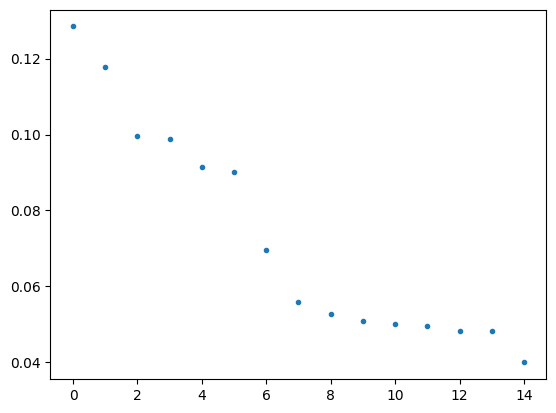

In [194]:
stdMessage = np.std(r['message'],axis = 0)
a = np.argsort(stdMessage)[::-1][None, :15]
c = stdMessage[a]
plt.plot(c[0], '.')
plt.show()

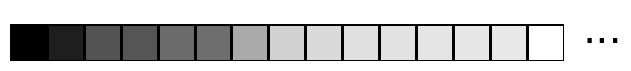

In [186]:
getSparsityPlot(r['message'], videoOut = False)

In [155]:
def plotDegreeLoss(degreeList, errorList, option = 'mean'):

    # either along x axis, y axis, or the mean
    if option == 'mean':
        errorList = np.mean(errorList, axis = -1)
    elif option == 'x':
        errorList = errorList[:, 0]
    elif option == 'y':
        errorList = errorList[:, 1]

    else:
        print("ISSUE >>>>>>>>>>>>>>>>>><<< plot degree - error badly initialized")
    
    
    maxBin = min(np.max(degreeList), 8)
    bins = np.arange(maxBin+2) - 0.5

    plotBoxPlot(degreeList, errorList, bins, xlabel = 'Degree', ylabel = 'L1 Error')

    return None

In [156]:
def errorsDiv(pred, gt):
    
    v = np.pi * 2
    anglePred = np.arctan2(pred[:, 1], pred[:, 0])
    angleGT = np.arctan2(gt[:, 1], gt[:, 0])

    normPred = np.linalg.norm(pred, axis=-1)
    normGT = np.linalg.norm(gt, axis=-1)

    errorNorm = np.abs(normPred - normGT)
    errorAngle = errorAngle = np.abs((anglePred - angleGT + np.pi) % (2 * np.pi) - np.pi)

    return errorAngle, errorNorm


In [233]:
def plotSpeedEffect(speed, error, namePlot, wbBool = False):

    plt.scatter(speed, error)
    plt.xlabel('Speed')
    plt.ylabel('Error')
    if wbBool:
        wandb.log({f"{namePlot}": wandb.Image(plt)})
    else:
        plt.savefig(namePlot)
    plt.close()

In [220]:
def evaluateModel(model, sim_data, display_dict, device = DEVICE):
    """ 
    Args:
    -----
        - `model`: GNN to test
        - `data`: list of SimulationData (to get the graphs)
        # might want to put a list of path instead for memory (should be fine though)
    """

    res = {}
    nbCall = 0

    evalLoss = 0
    distList = []           # list of distances
    errorList = []          # list of errors
    degreeList = []         # list of degrees
    normError = []          # list of norm errors
    angleError = []         # list of angles errors
    speedList = []              # list of speeds
    messages = None
    

    for sim in sim_data:
        data = sim.data

        for graph in data:

            graph = graph.to(device)
            pos = graph.x[:, :2]
            graph.x = graph.x[:, 2:]
            graph = normalizeGraph(graph)
            pred = model(graph)  
            
            graph.y = torch.swapaxes(graph.y, 0, 1)


            evalLoss += torch.nn.functional.l1_loss(pred.reshape(-1), graph.y[0, :, :].reshape(-1))
            nbCall += pred.reshape(-1).shape[0]

            #errors = torch.mean(torch.abs(pred - graph.y[0, :, :]),dim = -1)
            errors = torch.abs(pred - graph.y[0, :, :])

            errorList.extend(errors.cpu().detach().numpy().tolist())


            # update the output dictionnary

            ##if display_dict['']['comp']:
             #   pass

            if display_dict['speed_effect_error']['comp']:
                s = np.sqrt((graph.x[:, 0] ** 2 + graph.x[:, 1] ** 2).cpu().detach().numpy())
                speedList.extend(s.tolist())

            if display_dict['degree_error']['comp']:
                degs = deg(graph.edge_index[0, :], num_nodes=graph.x.size(0))
                degreeList.extend(degs.cpu().detach().numpy().tolist())


            if display_dict['mean_distance_neighbors']['comp']:
                #dist = graph.edge_attr[:, 0]
                #distList.extend(dist.cpu().numpy().tolist()) 
                #if not cfg.degree_error:
                #    errorList.extend(errors.cpu().numpy().tolist())
                pass


            if display_dict['angle_error']['comp'] or display_dict['norm_error']['comp']:
                
                errorAngle, errorNorm = errorsDiv(pred.cpu().detach().numpy(), graph.y[0, :, :].cpu().detach().numpy())
                if display_dict['angle_error']['comp']:
                    normError.extend(errorNorm.tolist())
                if display_dict['norm_error']['comp']:
                    angleError.extend(errorAngle.tolist())


            if display_dict['sparsity_peaks']['comp'] or display_dict['sparsity_bar']['comp']:
                m = getStdMessage(model, graph.edge_attr)
                if messages is None:
                    messages = m
                else:
                    messages = np.vstack((messages, m))


            


    # saving results

    evalLoss = evalLoss / nbCall
    res['evalLoss'] = evalLoss

    errorList = np.array(errorList)
    res['errorList'] = errorList

    if display_dict['mean_distance_neighbors']['comp']:
        distList = np.array(distList)
        res['distList'] = distList

    if display_dict['degree_error']['comp']:
        degreeList = np.array(degreeList)
        res['degreeList'] = degreeList

    if display_dict['angle_error']['comp']:
        angleError = np.array(angleError)
        res['angleError'] = angleError * 180 / np.pi

    if display_dict['norm_error']['comp']:
        normError = np.array(normError)
        res['normError'] = normError

    if display_dict['sparsity_peaks']['comp'] or display_dict['sparsity_bar']['comp']:
        res['message'] = messages

    if display_dict['speed_effect_error']['comp']:
        res['speed'] = speedList

    return res

In [221]:
print(data[0].data[0])

Data(x=[200, 8], edge_index=[2, 122], edge_attr=[122, 5], y=[10, 200, 2])


In [222]:
data = []
for i in range(5):

    xList, yList, attrList, indsList = getSim()
    simul_graphs = [Data(x = xList[t], y = yList[t] , edge_attr = attrList[t], edge_index = indsList[t]) for t in range(len(xList))]
    s = SimulationData(simul_graphs)
    data.append(s)
    
r = evaluateModel(model, data, d, device = DEVICE)

v0:60, tau:3.5, k:70, epsilon:0.5


  5%|▌         | 10/200 [00:00<00:02, 92.67it/s]

100%|██████████| 200/200 [00:01<00:00, 120.41it/s]


v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 200/200 [00:01<00:00, 127.71it/s]


v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 200/200 [00:01<00:00, 113.33it/s]


v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 200/200 [00:02<00:00, 73.64it/s] 


v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 200/200 [00:01<00:00, 114.35it/s]


In [234]:
import wandb

def saveLoader(d, display_dict):
    """ 
    Function to obtain the satistics 
    """

    resPandas = {}

    if display_dict['sparsity_peaks']['comp']:
        if display_dict['sparsity_peaks']['plot']:
            plotStdMessage(d['message'])
            plt.savefig(display_dict['sparsity_peaks']['plot'])
            plt.close()
        if display_dict['sparsity_peaks']['wandb']:
            plotStdMessage(d['message'])
            wandb.log({f"{display_dict['sparsity_peaks']['wandb']}": wandb.Image(plt)})
            plt.close()
        if display_dict['sparsity_peaks']['pandas']:
            pass


    if display_dict['sparsity_bar']['comp']:
        if display_dict['sparsity_bar']['plot']:
            getSparsityPlot(d['message'], videoOut = False)
            plt.savefig(display_dict['sparsity_bar']['plot'])
            plt.close()
        if display_dict['sparsity_bar']['wandb']:
            getSparsityPlot(d['message'], videoOut = False)
            wandb.log({f"{display_dict['sparsity_bar']['wandb']}": wandb.Image(plt)})
            plt.close()
        if display_dict['sparsity_bar']['pandas']:
            pass


    if display_dict['angle_error']['comp']:
        if display_dict['angle_error']['plot']:
            plt.hist(d['angleError'], bins = 'auto', density=True)
            plt.savefig(display_dict['angle_error']['plot'])
            plt.close()
        if display_dict['angle_error']['wandb']:
            wandb.log({'Median Angle Error':np.median(d['angleError']) })
        if display_dict['angle_error']['pandas']:
            resPandas['Angle error'] = np.median(d['angleError'])


    if display_dict['norm_error']['comp']:
        if display_dict['norm_error']['plot']:
            plt.hist(d['angleError'], bins = 'auto', density=True)
            plt.savefig(display_dict['norm_error']['plot'])
            plt.close()
        if display_dict['norm_error']['wandb']:
            wandb.log({'Median Norm Error':np.median(d['normError']) })
        if display_dict['norm_error']['pandas']:
            resPandas['Norm error'] = np.median(d['normError'])


    #if display_dict['dist']['comp']:
    #    pass


    if display_dict['degree_error']['comp']:
        if display_dict['degree_error']['plot']:
            plotDegreeLoss(d['degreeList'], d['errorList'])
            plt.savefig(display_dict['degree_error']['plot'])
            plt.close()
        if display_dict['degree_error']['wandb']:
            plotDegreeLoss(d['degreeList'], d['errorList'])
            wandb.log({f"{display_dict['degreeList']['wandb']}": wandb.Image(plt)})
            plt.close()
        if display_dict['degree_error']['pandas']:
            # get median values for the different degrees
            # add them to the pandas dict
            pass


    if display_dict['speed_effect_error']['comp']:
        if display_dict['speed_effect_error']['plot']:
            baseName = display_dict['speed_effect_error']['plot'][:-4]
            plotSpeedEffect(d['speed'], d['angleError'], baseName + '_anlge.png')
            plotSpeedEffect(d['speed'], d['normError'], baseName + '_norm.png')
            plotSpeedEffect(d['speed'], np.mean(d['errorList'], axis = -1), baseName + '_mean.png')
            plotSpeedEffect(d['speed'], d['errorList'][:, 0], baseName + '_comp_0.png')
            plotSpeedEffect(d['speed'], d['errorList'][:, 1], baseName + '_comp_1.png')
        if display_dict['speed_effect_error']['wandb']:
            plotSpeedEffect(d['speed'], np.mean(d['errorList'], axis = -1), 'mean Error', wbBool = True)
        if display_dict['speed_effect_error']['pandas']:
            pass




In [235]:
print(len(r['errorList']))

189000


In [236]:
print(len(r['speed']))

189000


In [237]:
print(np.array(r['speed']).shape)

(189000,)


In [238]:
print(np.array(r['errorList']).shape)

(189000, 2)


In [239]:
print(len(np.unique(r['speed'])))

83690


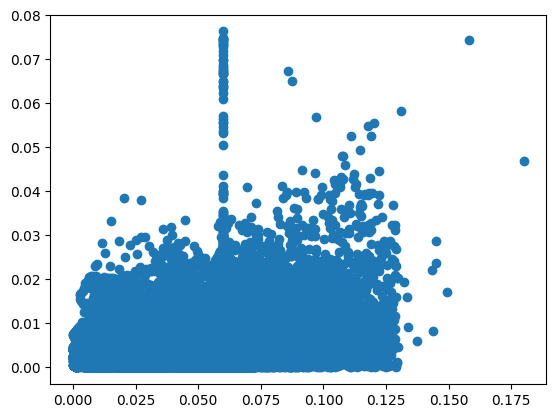

In [240]:
plt.scatter(r['speed'], r['errorList'][:, 1])

In [241]:
saveLoader(r, d)